In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
image_size = 784
hidden_size = 200
latent_dim = 50
batch_size = 128
epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data_dir = 'VAE_Samples'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

batch_size = 1
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1 = nn.Linear(image_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, image_size)
        self.relu = nn.LeakyReLU(negative_slope=0.05)
        #self.sig  = nn.Hardtanh(min_val=0.0, max_val=1.0)
        self.sig  = nn.Sigmoid()
    
    def encode(self, x):
        x = x.view(-1, image_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x
    
    def decode(self, z):
        z = self.fc3(z)
        z = self.relu(z)
        z = self.fc4(z)
        z = self.sig(z)
        return z
    
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out

    
class CnnAutoEncoder(nn.Module):
    def __init__(self):
        super(CnnAutoEncoder, self).__init__()
        #nn.BatchNorm2d(32)
        #nn.MaxPool2d(kernel_size=2,stride=2)
        #nn.Dropout2d(p=0.2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1)
        self.fc_in_1 = nn.Linear(128*784, hidden_size)
        self.fc_in_2 = nn.Linear(hidden_size, latent_dim)
        self.relu = nn.LeakyReLU(negative_slope=0.05)
        self.fc_out_1 = nn.Linear(latent_dim, hidden_size)
        self.fc_out_2 = nn.Linear(hidden_size, image_size)
        #self.sig  = nn.Hardtanh(min_val=0.0, max_val=1.0)
        self.sig  = nn.Sigmoid()
    
    def encode(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, image_size * 128)
        x = self.fc_in_1(x)
        x = self.relu(x)
        x = self.fc_in_2(x)
        return x
    
    def decode(self, z):
        z = self.fc_out_1(z)
        z = self.relu(z)
        z = self.fc_out_2(z)
        z = self.sig(z)
        return z
    
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out
    
    
class DeNoiseAutoEncoder(nn.Module):
    def __init__(self):
        super(DeNoise, self).__init__()
        pass
    def encode(self, x):
        pass
    def decode(self, z):
        pass
    def forward(self, x):
        pass
    
model = CnnAutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [8]:
def plot_images(image, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed')

    plt.show()
    
    
def loss_function(reconstructed_image, original_image, mu, logvar):
    bce = F.binary_cross_entropy(reconstructed_image, original_image.view(-1, 784), reduction = 'sum')
    # kld = torch.sum(0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar, 1))
    # kld = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
    return bce # + kld


def train(model, epoch):
    model.train()
    train_loss = 0
    for idx, (images, label) in enumerate(train_loader):
        images = images.to(device)
        reconstructed = model(images)
        
        loss = loss_function(reconstructed, images, 0, 0)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if (idx) % 1000 == 0:
            print("Train Epoch {} [Batch {}/{}]\tLoss: {:.3f}".format(epoch, idx, len(train_loader), loss.item()/len(images)))
            original = images[0].to("cpu")
            original = original.view(28,28).detach().numpy()
            re_img = reconstructed[0].to("cpu")
            re_img = re_img.view(28,28).detach().numpy()
            plot_images(image=original, reconstructed=re_img)
    print("===> Epoch {}, Average loss: {:.3f}".format(epoch, train_loss/len(train_loader.dataset)))

    
def val(model):
    model.eval()
    model.to("cpu")
    test_loss = 0
    
    latent_array = None
    label_list = list()
    
    device = "cpu"
    
    for idx, (images, label) in enumerate(test_loader):
        
        images.detach()
        
        images = images.to(device)
        reconstructed = model(images)
        reconstructed.detach()
        loss = loss_function(reconstructed, images, 0, 0)
        
        label_list.append(float(label))
        
        latent_val = model.encode(images)
        latent_val = latent_val.cpu()
        
        if latent_array is None:
            latent_array = latent_val
        else:
            latent_array = torch.cat((latent_array, latent_val), dim=0)
                    
        test_loss += loss.item()
        if (idx) % 3000 == 0:
            print("Test image idx {}, latent var value: {}, label: {}".format(idx, model.encode(images), label))
            original = images[0].to("cpu")
            original = original.view(28,28).detach().numpy()
            re_img = reconstructed[0].to("cpu")
            re_img = re_img.view(28,28).detach().numpy()
            plot_images(image=original, reconstructed=re_img)
    print("===> Test, Average loss: {:.3f}".format(test_loss/len(test_loader.dataset)))
    
    return latent_array, label_list
    
    
def plot_latenet(latent, label_list, algo='tsne'):
    if not type(algo) == str:
        raise ValueError("-E- Algo Input must be String")
    latent_array = latent.detach().cpu()
    algo = algo.lower()
    if algo == 'tsne':
        result = TSNE(n_components=2, perplexity=100).fit_transform(latent_array)
    elif algo == 'pca':
        pca = PCA(n_components=2)
        pca.fit(latent_array)
        result = pca.transform(latent_array)
    plt.scatter(result[:, 0], result[:, 1], c=label_list)
    

Train Epoch 0 [Batch 0/469]	Loss: 544.244


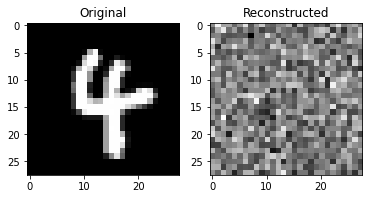

===> Epoch 0, Average loss: 98.116
Train Epoch 1 [Batch 0/469]	Loss: 64.277


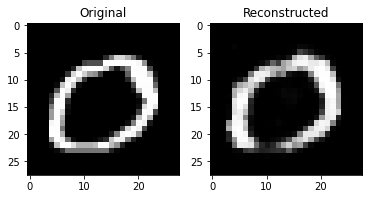

===> Epoch 1, Average loss: 64.125
Train Epoch 2 [Batch 0/469]	Loss: 61.947


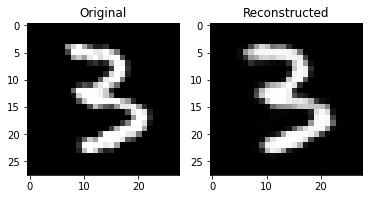

===> Epoch 2, Average loss: 61.499
Train Epoch 3 [Batch 0/469]	Loss: 59.551


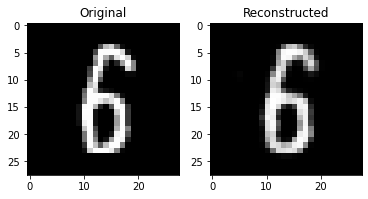

===> Epoch 3, Average loss: 60.280
Train Epoch 4 [Batch 0/469]	Loss: 59.749


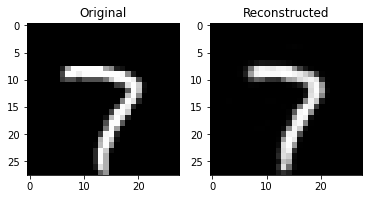

===> Epoch 4, Average loss: 59.601


In [5]:
for i in range(5):
    train(model=model, epoch=i)

Test image idx 0, latent var value: tensor([[  0.9186, -22.1839,  16.4264,  11.9712,  17.2764,  -1.2759,  17.0167,
           2.3314, -34.4133,   0.4818,  -3.4307,   2.6882,   7.5855,   2.0337,
         -32.3668,  -1.9204,   6.3344, -12.2049,  -8.3975,   9.1292, -11.8962,
           0.9911,  13.1115, -10.0849, -15.8222,  -1.1403,   1.0441,  10.2387,
           6.9634, -17.8591,  -9.9950,  22.0218, -17.2859,   2.2819,  -1.9928,
          -0.4398,   8.8989, -13.1613,  -8.0308,   4.2750,   6.6566,  -5.2252,
         -10.4008, -25.9815,   3.7873,  11.9357, -33.2716,   1.6617,   8.3624,
          -0.8269]], grad_fn=<AddmmBackward>), label: tensor([7])


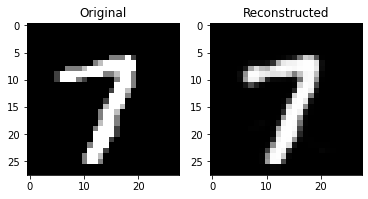

Test image idx 3000, latent var value: tensor([[ 19.2936,  -3.4210,   8.9123, -15.3145,  19.7593, -11.9265,  23.5890,
         -12.1799,  -9.8897,  -2.6306,  -0.9313,   5.0558, -18.3998, -12.9288,
         -26.6675, -22.8618,  25.8906,  -4.3946,  10.9644,  -4.5694,   1.1310,
          -4.8032,  19.6339,   4.9565, -12.2344,  -0.8327,  -6.9631,   2.8615,
           4.4890, -34.4837,  15.2484,   9.1385,  -7.7381,   6.1125,   0.7647,
           0.7334,   5.6951,   7.7064,   0.4830,   2.4151,   2.5454,   2.7964,
          -3.0940, -20.8436,  -6.6533,   1.7071, -33.4402, -17.3091,  21.6961,
           1.7212]], grad_fn=<AddmmBackward>), label: tensor([0])


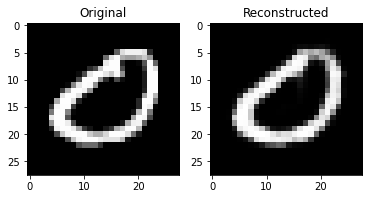

Test image idx 6000, latent var value: tensor([[ -1.7284,  -6.0780,  21.1328,  24.7860,  28.4189,  12.9649,  15.9090,
         -14.6227, -13.4510,  16.5880,  -4.2499,  15.5492,  16.6710,  -1.6115,
         -27.3416,   9.6452,  -0.5289, -20.5851,   7.0148,  -5.4114, -12.6236,
           1.7069,  13.3318,   7.7580,  -8.8657,  11.4023,  -2.7511,  11.1848,
          -0.0604, -34.3710,  -3.4296,   8.3192, -13.1876,   3.8572,   9.9508,
           1.3230,   7.1649,  -2.9369,  -9.9425,  -8.7882, -10.4941, -12.2121,
          -6.7147, -26.3988,   2.8987,  14.0429, -29.5714,   2.2036,  21.9501,
          -5.0881]], grad_fn=<AddmmBackward>), label: tensor([8])


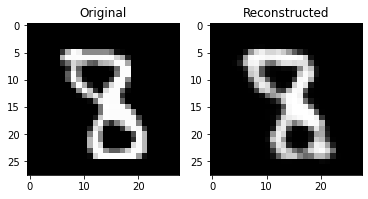

Test image idx 9000, latent var value: tensor([[ 26.5315,   4.9376,  23.2670,  25.7073,  26.2677,   9.7909,  27.5816,
         -14.8023, -29.3338, -17.0630, -13.0853, -10.8292,   4.0156, -18.6682,
         -18.0103,  -9.2441,  -1.6589,  -4.5807,  12.8948, -23.5097,  -0.1094,
           2.4216,  -1.2667,   5.6815, -16.4752,   1.4336,  -1.2084,   2.3325,
          10.0204, -37.1867,  -5.0527,   6.0294,   6.5026,   4.4194,  12.4048,
          -6.2333,  16.1122,  -7.2554,   3.2405, -13.4812, -17.2803,   2.3284,
         -27.4189, -13.1428,   1.5075,  -6.2263, -33.6798,  -8.2968,  13.6352,
         -10.0828]], grad_fn=<AddmmBackward>), label: tensor([6])


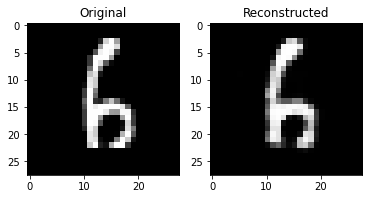

===> Test, Average loss: 59.101


In [6]:
latent, labels = val(model)

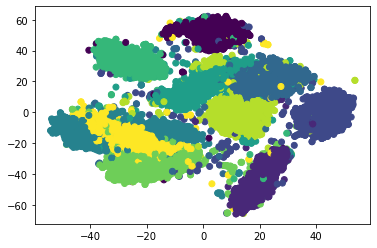

In [10]:
plot_latenet(latent, labels, algo='tsne')

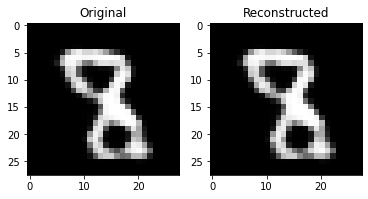

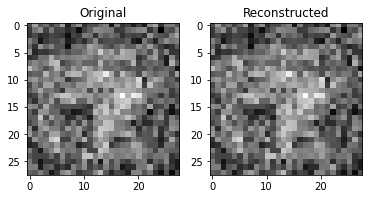

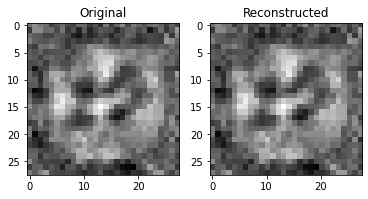

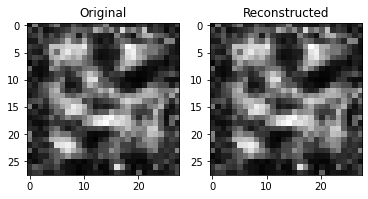

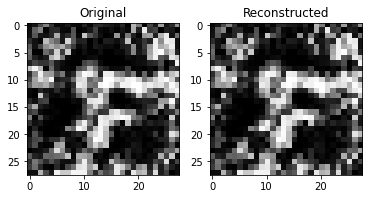

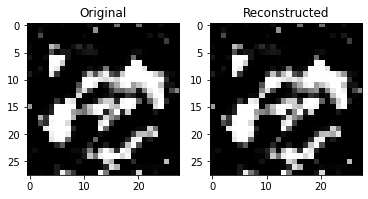

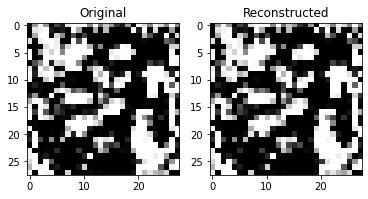

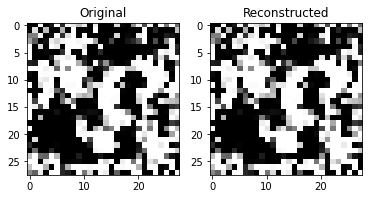

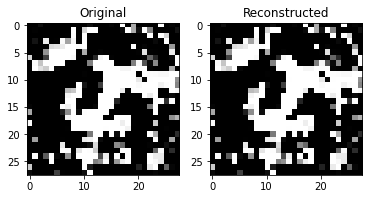

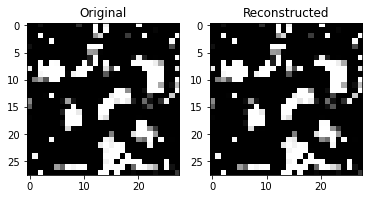

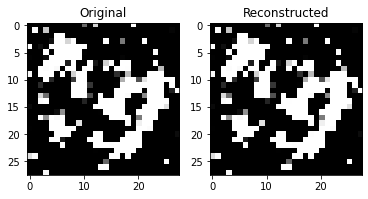

In [39]:
for i in range(10):
    z = torch.tensor([[  0.9186, -22.1839,  16.4264,  11.9712,  17.2764,  -1.2759,  17.0167,
               2.3314, -34.4133,   0.4818,  -3.4307,   2.6882,   7.5855,   2.0337,
             -32.3668,  -1.9204,   6.3344, -12.2049,  -8.3975,   9.1292, -11.8962,
               0.9911,  13.1115, -10.0849, -15.8222,  -1.1403,   1.0441,  10.2387,
               6.9634, -17.8591,  -9.9950,  22.0218, -17.2859,   2.2819,  -1.9928,
              -0.4398,   8.8989, -13.1613,  -8.0308,   4.2750,   6.6566,  -5.2252,
             -10.4008, -25.9815,   3.7873,  11.9357, -33.2716,   1.6617,   8.3624,
              -0.8269]]) * 0 + torch.randn(1,latent_dim) * (i ** 2)
    image = model.decode(z=z).view(28,28).detach().numpy() 
    plot_images(image=image, reconstructed=image) 